In [2]:
import numpy as np
from os.path import join
import tensorflow as tf
from tensorflow import keras
from keras import layers, initializers
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import layer_utils
from keras import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import matplotlib.pyplot as plt

2022-02-10 18:01:49.623884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 18:01:49.623950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Building Model

### Custom Code

In [ ]:
def identity_block(img, f_size, filters):
    F1,F2,F3 = filters
    img_shortcut = img
    
    img = Conv2D(filters=F1, kernel_size=1, strides=(1,1), padding='valid')(img)
    img = BatchNormalization(axis=3)(img)
    img = Activation('relu')(img)

    img = Conv2D(filters=F2, kernel_size=f_size, strides=1, padding="same")(img)
    img = BatchNormalization(axis=3)(img)
    img = Activation('relu')(img)

    img = Conv2D(filters=F3, kernel_size=1, strides=1, padding="valid")(img)
    img = BatchNormalization(axis=3)(img)

    img = Add()([img, img_shortcut])
    img = Activation('relu')(img)

    return img

In [ ]:
def convolutional_block(img, f_size, filters, s=2):
    F1,F2,F3 = filters
    img_shortcut = img

    img = Conv2D(filters=F1, kernel_size=1, strides=s)(img)
    img = BatchNormalization(axis=3)(img)
    img = Activation('relu')(img)

    img = Conv2D(filters=F2, kernel_size=f_size, strides=1, padding="same")(img)
    img = BatchNormalization(axis=3)(img)
    img = Activation('relu')(img)

    img = Conv2D(filters=F3, kernel_size=1, strides=1, padding="valid")(img)
    img = BatchNormalization(axis=3)(img)

    img_shortcut = Conv2D(F3, 1, s, padding='valid')(img_shortcut)
    img = BatchNormalization(axis=3)(img)

    img = Add()([img, img_shortcut])
    img = Activation('relu')(img)

    return img


In [ ]:
def ResNet50(input_shape=(224,224,3),classes = 25):
    img_input = Input(input_shape)

    img = ZeroPadding2D((3,3))(img_input)

    #1
    img = Conv2D(64,7,2)(img)
    img = BatchNormalization(axis=3)(img)
    img = Activation('relu')(img)
    img = MaxPooling2D((3,3),strides=(2,2))(img)

    #2
    img = convolutional_block(img, 3, [64,64,256])
    img = identity_block(img, 3, [64,64,256])
    img = identity_block(img, 3, [64,64,256])

    #3
    img = convolutional_block(img, 3, [128,128,512])
    img = identity_block(img, 3, [128,128,512])
    img = identity_block(img, 3, [128,128,512])
    img = identity_block(img, 3, [128,128,512])
    
    #4
    img = convolutional_block(img, 3, [256,256,1024])
    img = identity_block(img, 3, [256,256,1024])
    img = identity_block(img, 3, [256,256,1024])
    img = identity_block(img, 3, [256,256,1024])
    img = identity_block(img, 3, [256,256,1024])
    img = identity_block(img, 3, [256,256,1024])

    #5
    img = convolutional_block(img, 3, [512,512,2048])
    img = identity_block(img, 3, [512,512,2048])
    img = identity_block(img, 3, [512,512,2048])

    #avgpool
    img = AveragePooling2D((2,2),name="avgpool")(img)


    #output_layer
    img = Flatten()(img)
    img = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(img)

    #model
    model = Model(inputs= img_input, outputs= img, name="ResNet50")

    return model
    


In [ ]:
#model = ResNet50(((224,224,1))) # FOR HOG FEAUTURES
model = ResNet50()

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
#model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy', metrics.top_k_categorical_accuracy])
# tf dataset
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
model.summary()

### Keras Applications

In [2]:
def initModel(train_layers=1):
    base_model = keras.applications.ResNet50(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(224, 224, 3),
        include_top=False
        )
    base_model.trainable = False
    
    for layer in base_model.layers[-train_layers:]: # Hyper-parameter trainable layers in base_model
        layer.trainable = True
        print(len(layer.trainable_weights))
        
    trainable = sum([1 for layer in base_model.layers if len(layer.trainable_weights) != 0 ])
    trainable = trainable + int(trainable/2)
    non_trainable = len(base_model.layers)-trainable
    print("trainable  "  + str(trainable) + "  non_trainable " +  str(non_trainable))
    
    
#     for layer in base_model.layers:
#         print(">>> " + str(len(layer.trainable_weights)))
    inputs = keras.Input(shape=(224, 224, 3))
    inputs = tf.keras.applications.resnet50.preprocess_input(
        inputs, data_format=None
    )
    
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal'),
      tf.keras.layers.RandomRotation(0.2),
    ])
    inputs = data_augmentation(inputs)
    

    x = base_model(inputs,training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)

    outputs = keras.layers.Dense(25, activation='softmax', name='fc' + str(25),kernel_initializer=glorot_uniform(seed=0))(x)

    model = keras.Model(inputs, outputs)
    return model

In [ ]:
inputs

In [8]:
model = initModel(1)
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

0
trainable  0  non_trainable 175


In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 fc25 (Dense)                (None, 25)                51225     
                                                                 
Total params: 23,638,937
Trainable params: 51,225
Non-trainable params: 23,587,712
_________________________________________________________________


<h1>Data Collection</h1>

# Numpy Arrays

## Training data

In [ ]:
import os
from os.path import join
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
use_HOG = True
print ("Using HOG " , end="")
print("True") if use_HOG else print("False")
img_size = (224,224) 
data_path = "./data/wikipaintings_small/wikipaintings_train"
class_names = os.listdir(data_path)
x_train = []
y_train = []
classes = []
for class_name in class_names:
    class_path = join(data_path, class_name)
    img_names = os.listdir(class_path)
    classes.append(class_name)
    for img_name in img_names:
        img = load_img(join(class_path, img_name),target_size=img_size)
        if use_HOG == True :
            fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
            img_arr = img_to_array(hog_image)
        else:
            img_arr = img_to_array(img)
            
        x_train.append(img_arr)
        y_train.append(class_name)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.astype('float32')/255.0


In [ ]:
x_train.shape

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(y_train)
print(transfomed_label)
transfomed_label.shape

In [ ]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# y=imgs_df['class'].values
# print(y[:15])
# print(y_train[:15])

# y_labelenc = LabelEncoder()
# y=y_labelenc.fit_transform(y)

# y=y.reshape(-1,1)
# onehotenc = OneHotEncoder(categorical_features=[0])
# Y=onehotenc.fit_transform(y)
# Y.shape

In [ ]:
transformed_label.shape

## Testing data

In [ ]:
import os
from os.path import join
from keras.preprocessing.image import load_img
img_size = (224,224) 
data_path = "../rasta/data/wikipaintings_small/wikipaintings_test"
class_names = os.listdir(data_path)
x_test = []
y_test = []
for class_name in class_names:
    class_path = join(data_path, class_name)
    img_names = os.listdir(class_path)
    classes.append(class_name)
    for img_name in img_names:
        img = load_img(join(class_path, img_name),target_size=img_size)
        if use_HOG == True :
            fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
            img_arr = img_to_array(hog_image)
        else:
            img_arr = img_to_array(img)
        
        x_test.append(img_arr)
        y_test.append(class_name)
x_test = np.array(x_train)
y_test = np.array(y_train)
x_test = x_train.astype('float32')/255.0


In [ ]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_test = encoder.fit_transform(y_test)
print(y_test)
y_test.shape

# TF DATASETS 

In [9]:
def get_datasets(data_dir="../rasta/data/wikipaintings_small", img_size=(224,224),batch_size=32):
   
    #training
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
    join(data_dir, "wikipaintings_train"),
    image_size=img_size,
    batch_size=batch_size)
    
    for image_batch, labels_batch in train_ds:
        print(image_batch.shape)
        print(labels_batch.shape)
        break
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
    join(data_dir, "wikipaintings_val"),
    image_size=img_size,
    batch_size=batch_size)
    
    for image_batch, labels_batch in val_ds:
        print(image_batch.shape)
        print(labels_batch.shape)
        break
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
    join(data_dir, "wikipaintings_test"),
    image_size=img_size,
    batch_size=batch_size)

    for image_batch, labels_batch in test_ds:
        print(image_batch.shape)
        print(labels_batch.shape)
        break    
    

########################################################################################

#     normalization_layer = tf.keras.layers.Rescaling(1./255)
#     normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

########################################################################################

#     class_names = train_ds.class_names

#     plt.figure(figsize=(10, 10))
#     for images, labels in train_ds.take(1):
#           for i in range(9):
#                 ax = plt.subplot(3, 3, i + 1)
#                 plt.imshow(images[i].numpy().astype("uint8"))
#                 plt.title(class_names[labels[i]])
#                 plt.axis("off")
    return train_ds,val_ds,test_ds
#     return normalized_train_ds, normalized_val_ds

In [10]:
# train_ds, val_ds = get_datasets()
train_ds,val_ds,test_ds = get_datasets()

Found 250 files belonging to 25 classes.
(32, 224, 224, 3)
(32,)
Found 248 files belonging to 25 classes.
(32, 224, 224, 3)
(32,)
Found 250 files belonging to 25 classes.
(32, 224, 224, 3)
(32,)


## Model Fit

In [11]:
# model.fit(tain_img, labels, )
initial_epochs = 10
# saving model after each epoch
metric = 'val_accuracy'
filepath="my_models/pretrained_1unnorm_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
# csv_logger = CSVLogger('logs/pretrained_1unnorm.log',separator=",", append=True)
callbacks_list = [checkpoint,earlystopping]

history=model.fit(train_ds, validation_data=val_ds,epochs=initial_epochs,callbacks=callbacks_list, verbose=1)
#model.fit(train_ds, validation_data=val_ds,epochs=1, verbose =1)

Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 3.6341 - accuracy: 0.1200
Epoch 00001: val_accuracy improved from -inf to 0.13710, saving model to my_models\pretrained_1unnorm_1.hdf5
8/8 [==============================] - 55s 7s/step - loss: 3.6341 - accuracy: 0.1200 - val_loss: 3.3801 - val_accuracy: 0.1371
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 2.0349 - accuracy: 0.4440
Epoch 00002: val_accuracy improved from 0.13710 to 0.20968, saving model to my_models\pretrained_1unnorm_1.hdf5
8/8 [==============================] - 50s 7s/step - loss: 2.0349 - accuracy: 0.4440 - val_loss: 3.1011 - val_accuracy: 0.2097
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 1.2270 - accuracy: 0.6920
Epoch 00003: val_accuracy improved from 0.20968 to 0.23387, saving model to my_models\pretrained_1unnorm_1.hdf5
8/8 [==============================] - 52s 7s/step - loss: 1.2270 - accuracy: 0.6920 - val_loss: 2.9910 - val_accuracy: 0.2339
Epoch 4/10

In [12]:
preds = model.evaluate(test_ds)

8/8 [==============================] - 26s 3s/step - loss: 3.1511 - accuracy: 0.1800


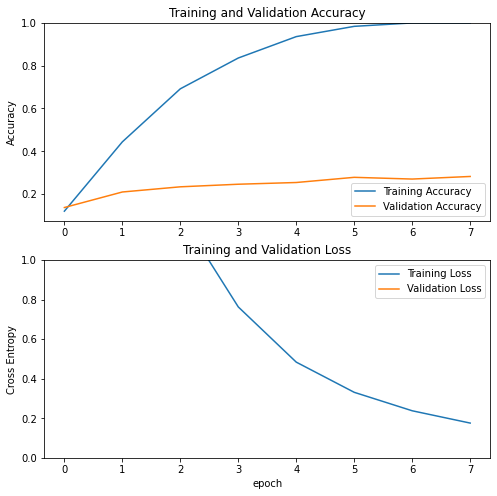

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Augmentation Testa Data


In [ ]:
def imagenet_preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [ ]:
test_ds = test_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
test_ds = test_ds.map(
  lambda x, y: (imagenet_preprocess_input(x), y))
preds = model.evaluate(test_ds)

In [ ]:
model.save("my_models/pretrained_1Aug_1HOG_0.h5")

## Fine Tuning

In [ ]:
# model = load_model("my_models/pretrained_1Aug_1HOG_0.h5")
# model.summary()

In [ ]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
# fine tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
model.compile(
  optimizer=keras.optimizers.RMSprop(1e-5),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])
model.summary()

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
metric = 'val_accuracy'
filepath="my_models/pretrained_1Aug_1HOG_0_fineTune.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True)
# csv_logger = CSVLogger('pretrained_1Aug_1HOG_0_fineTune.log',separator=",", append=True)
callbacks_list = [checkpoint,earlystopping]

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=total_epochs,
                         callbacks=callbacks_list,
                         initial_epoch=history.epoch[-1],
                         verbose=1)

### FINE-TUNE PY PLOTS

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### FINE TUNE EVALUATION

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

### EVALUATION VISUALIZATION

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")